# Unit 3 Capstone: Predicting which type of beer a recipe will produce

Using a dataset from Kaggle ( https://www.kaggle.com/jtrofe/beer-recipes ), this project attempts to devise a machine-learning model capable of predicting the type of beer (out of a list of 13 broad categories) that was (or would be) produced, using data from the beer production process, such as the specific density of the mixture at various points in the process, the color or bitterness of the product, the temperature it's kept at during brewing, etc.

Many thanks to Samuel Lachance and James Shepherd for the inspiration and a bit of coding that I took from their looks into the same dataset.  

## Proposal
Sifting through the datasets on Kaggle for a likely candidate for this project, I came across the Brewer's Friend dataset and found that it ticked all of the boxes I was looking for: large but not too-large sample size, a reasonable but not unmanageable number of features already present, and an interesting problem that might or might not be solvable by machine learning algorithms.

Specifically, the question that sprang to mind was: "Can I use machine learning to predict the type of beer produced, given the data provided about the brewing process?"  I've encountered a fair amount of success at engineering such a model, albeit with some important caveats.  

Whether such a model would have practical use I'm not entirely certain, as I don't know what the exact needs of the beer industry are, but one possibility I can think of is that it would offer a semi-reliable method of double-checking what a new brew "should" be called, if the brewer is uncertain.

## Data Analysis

After cleaning up outliers and removing columns that were so filled with null values they weren't salvageable, a peek through the data revealed that it's a highly complicated dataset.  While the broad types that I've grouped them into do have distinctly different means and relatively normal distributions for most of the features, there are so many outliers, and so much space shared between each broad type, that this is unlikely to be an easy-to-model dataset.

To see what I mean, the boxplots below show the spread of the most _useful_ features in the dataset, according to SelectKBest, for each member of the target class, BroadStyle.  (For a more detailed look, see the bottom of the notebook, where more graphs are available.)

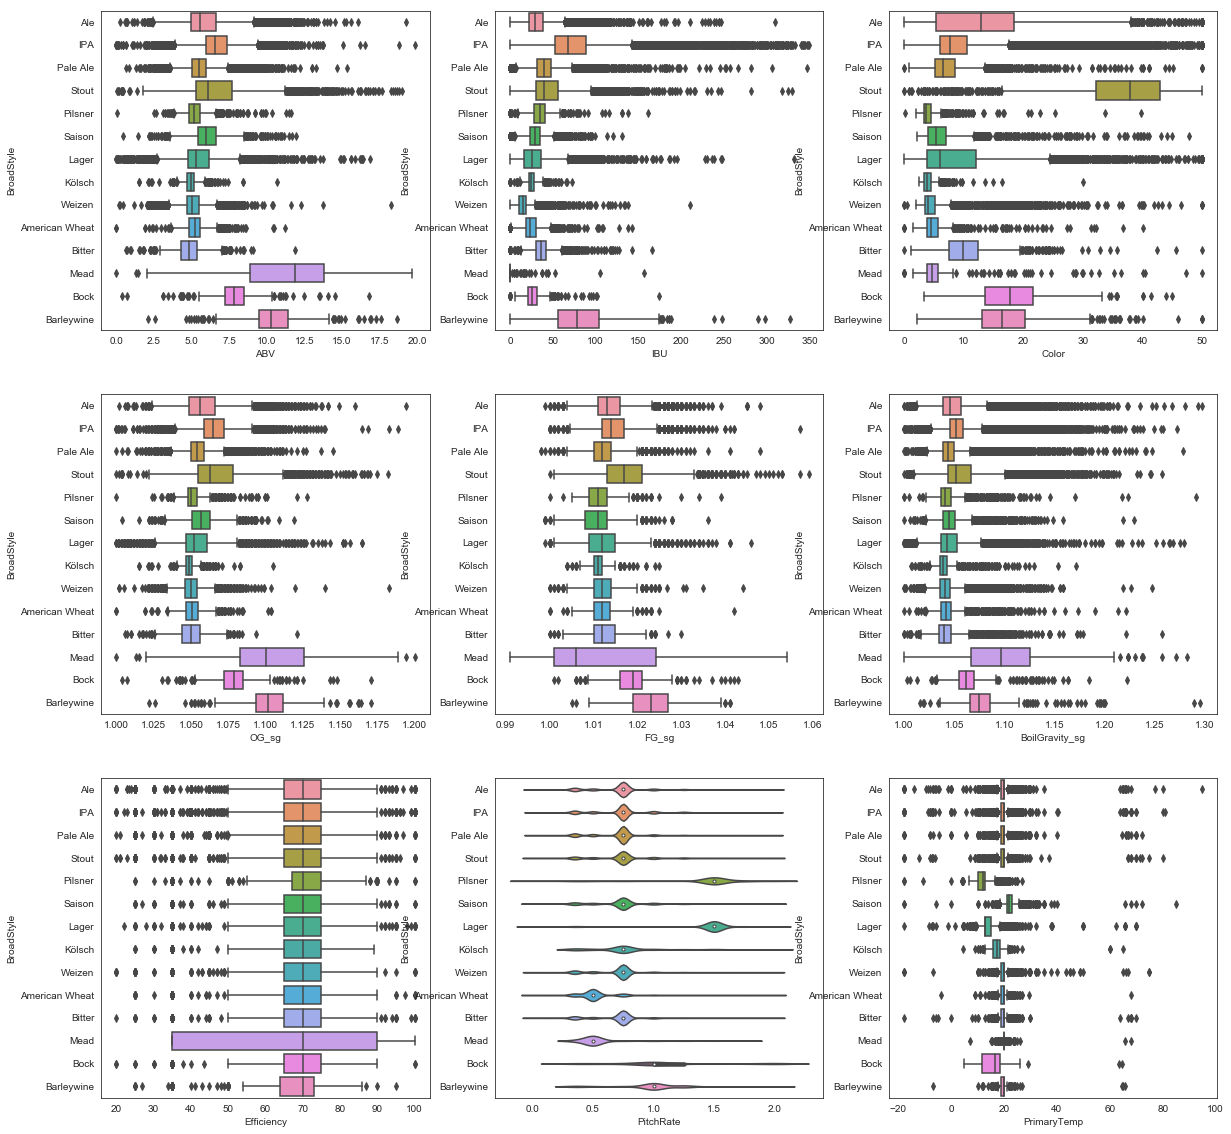

In [617]:
plt.figure(figsize=(20,20))

plt.subplot(331)
sns.boxplot(y = 'BroadStyle', x = 'ABV', data = beer_recipes)
plt.subplot(332)
sns.boxplot(y = 'BroadStyle', x = 'IBU', data = beer_recipes)
plt.subplot(333)
sns.boxplot(y = 'BroadStyle', x = 'Color', data = beer_recipes)
plt.subplot(334)
sns.boxplot(y = 'BroadStyle', x = 'OG_sg', data = beer_recipes)
plt.subplot(335)
sns.boxplot(y = 'BroadStyle', x = 'FG_sg', data = beer_recipes)
plt.subplot(336)
sns.boxplot(y = 'BroadStyle', x = 'BoilGravity_sg', data = beer_recipes)
plt.subplot(337)
sns.boxplot(y = 'BroadStyle', x = 'Efficiency', data = beer_recipes)
plt.subplot(338)
sns.violinplot(y = 'BroadStyle', x = 'PitchRate', data = beer_recipes)
plt.subplot(339)
sns.boxplot(y = 'BroadStyle', x = 'PrimaryTemp', data = beer_recipes)

So, to begin with, let's go over what the dataset has on it's own, and what the definitions its authors give to the features it contains:
* BeerID: Record ID
* Name: Name
* URL: Location of recipe webpage at https://www.brewersfriend.com
* Style: Type of brew
* StyleID: Numeric ID for type of brew
* Size(L): Amount brewed for recipe listed
* OG: Specific gravity of wort before fermentation
* FG: Specific gravity of wort after fermentation
* ABV: Alcohol By Volume
* IBU: International Bittering Units
* Color: Standard Reference Method - light to dark ex. 40 = black
* BoilSize: Fluid at beginning of boil
* BoilTime: Time wort is boiled
* BoilGravity: Specific gravity of wort before the boil
* Efficiency: Beer mash extraction efficiency - extracting sugars from the grain during mash
* MashThickness: Amount of water per pound of grain
* SugarScale: Scale to determine the concentration of dissolved solids in wort
* BrewMethod: Various techniques for brewing
* PitchRate: Yeast added to the fermentor per gravity unit - M cells/ml/deg P
* PrimaryTemp: Temperature at the fermenting stage
* PrimingMethod:N
* PrimingAmount: Amount of priming sugar used
* UserId

Of those, it's easy to toss out BeerID, Name, URL, StyleID, and UserID as being of no use to us for modeling purposes.

In [613]:
print('Number of rows in basedata_beer_recipes: ' + str(len(basedata_beer_recipes.index)))
print('')
print('Number of null values for each feature:')
print(basedata_beer_recipes.isnull().sum())
print('')
print('Number of unique values in Style: ' + str(basedata_beer_recipes['Style'].nunique()))

Number of rows in basedata_beer_recipes: 73861

Number of null values for each feature:
Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64

Number of unique values in Style: 175


Doing a quick check for null values reveals that PrimingMethod and PrimingAmount have so many null values as to be unsalvagable.  MashThickness and PrimaryTemp are missing less than half of their values, while PitchRate is missing just over half, so they should still be useful if we fill in the missing values with a median number, based on the broad style of beer they belong to.  The same goes for BoilGravity, which is only missing 3000 values.

Once we've dealt with those problem children, the biggest challenge is figuring out what to do with the Style feature.  There are 175 different styles in there, too many for a model to reliably be able to separate out the makings of a particular style from all the noise.  Mr. Lachance attempted this, and got a 37% accuracy rate for the highest-performing model he tried. ( https://www.kaggle.com/samlac79/beer-recipe-exploratory-analysis )

However, taking inspiration from Mr. Shepherd's analysis ( https://www.kaggle.com/shep312/brewer-s-friend-visualisations ), where he groups the styles into "broad styles," I ran his code (with a few modifications to catch weirdly-named styles) and collected them into a collection of 17 different BroadStyles, a number which eventually was condensed down to 13 during the course of my analysis.

This produced a more-manageable set of target classes for algorithms to predict, though it still proved remarkably challenging for them.

### The matter of specific gravity
One issue that Mr. Lachance came across, and which I'm grateful to him for devising an answer to, is that specific gravity is apparently measured in two very different ways, depending on the SugarScale used to do the measuring.  This results in massive outliers in the specific gravity features, as the Specific Gravity scale gives numbers somewhere between 1.0 and 2.0, while the Plato scale results in _much_ higher numbers being mixed in with those, resulting in an unnecessary mass of extreme outliers.

Fortunately, in the course of his analysis Mr. Lachance had already done the necessary research into this and wrote up a bit of code to convert any Plato-derived specific gravity data into something on the same scale as the rest of the applicable features, which I have gratefully borrowed and adapted in the 'get_sg_from_plato' and 'apply_get_sg' functions.

## SelectKBest

SelectKBest was performed twice, once on the baseline features (after filling in any null values) and once on the baseline features plus the PCAs that were created (detailed just below). The results were as follows:

Results for top features out of the original set were:
1. Color
2. PitchRate
3. IBU
4. PrimaryTemp
5. OG_sg
6. ABV
7. FG_sg
8. BoilGravity_sg
9. Efficiency
10. MashThickness

Results for top features out of everything including the two PCAs were:
1. properties_pca_2
2. Color
3. top_10_pca_3
4. PitchRate
5. properties_pca_1
6. IBU
7. top_10_pca_1
8. PrimaryTemp
9. top_10_pca_4
10. OG_sg

Let's take a look at the first set of 10.  

Color is an obvious candidate for deciding what kind of beer you're looking at.  If it's really dark, it's definitely not going to be a Pilsner or a Kolsch, and is more likely than not a Stout of some kind. The variation between the broad styles is largest in this feature, so it's unsurprising that it takes the top spot.

PitchRate is, if we look at the definitions, "the amount of yeast added per gravity unit," which would have a definite impact on the outcome of the brewing process.  I would have to ask a brewer or expert on beer to find the _exact_ effects that more or less yeast would have, but the basics are that the more yeast, the less sugar there is after a given amount of time fermenting, and vice-versa. The violin chart shows that, while every type is spread pretty widely between various pitch rates, there are six broad types that have strong clusters away from the other seven, which all cluster on 0.75.  That variation offers another distinguishing variable for an algorithm to use to differentiate one type from another.  It might be small, given how spread out the data points are, but in a dataset like this every little bit helps.

The rest of the features follow the same general pattern - some small amount of variation between the broad types in mean and standard deviation, with wide swathes of outliers for each broad type that would entirely confuse a human observer (or at least _this_, untrained, human observer).  The point is that each set of unique variations gives a smidgeon more detail to the algorithm for it to use in making its decision on which broad style to place a given brew into.

Perhaps the most surprising (to me, at least) feature to be included in the top 10 was Efficiency, due to its utter lack of variation in the means across the broad types.  While the standard deviations do shift between types (though only a little, with the exception of mead where it’s extremely broad), in the box plot the mean of each type forms a solid vertical line!  If I had more time to investigate, I’d definitely be interested in learning more about how the algorithm was using that feature.



## PCA selection
Moving on to the PCA features, I chose to do two relatively simple sets, one based on the top 10 (set to produce 5 PCA features) and the other collecting six correlated features out of the top 10: OG_sg, FG_sg, BoilGravity_sg, IBU, ABV, and Color, set to produce 3 PCA features.  

The SelectKBest review of the combined feature-set produced relatively unsurprising results.  properties_pca_2 and top_10_pca_3 are both nearly identical, and are likely tracking the same feature or combination of features that were input into the PCA algorithm; the same is true of top_10_pca_1 and properties_pca_1.  Including both sets of PCAs in the same SKB run is, probably, not the best bit of model design ever, but I was curious about which PCA would produce higher-performing results.

In testing with an actual model, the tendency for the ‘properties’ PCA to score higher with SKB was proved correct, as the model I chose for the final result of this project (GBC) was most effective using the base feature-set plus the ‘properties’ PCA.  Again, this isn’t terribly surprising, given that it was the PCA put together with a highly-correlated collection of features that were among the highest-scoring in the SKB test. 


## Algorithm comparison

Many of the algorithms that I'm going to be testing are, frankly, unsuited to this kind of dataset; they require cleaner demarkations between classes, or aren't designed to go deep enough into the logic of which properties belong to which classes to be successful.  Still, we'll give all of them a shot, just in case one surprises me.

Let's start by going over what are likely the biggest problems that any algorithm is going to run into here.  This particular dataset is highly complex, with lots of fuzziness around what goes into making a particular style of beer and multiple cases where recipes could be classed as one of a number of different styles.  Getting a 50% rating is (in my neophyte's eyes, at least) frankly _impressive_, as that's still a lot better than just guessing at random, given the number of styles to choose from.  Unfortunately, 50% is still not enough for even theoretically practical purposes; we need to pick a higher-performing algorithm that can get higher than 70%, at least.

The best results for each algorithm, out of all the featuresets tested, were as follows:

* Decision Tree:  55%
* Random Forest: 64%
* Gradient Boosting Classifier:	66.9%
* KNN:	57.9%
* Logistic Regression:	51%
* Naive Bayes:	40%
* Support Vector Machine Classifier:	61%

Unsurprisingly, the two simplest algorithms (Naive Bayes and Logistic Regression) were lackluster performers.  Neither has the ability to deal with the complexities in this particular data set; Naive Bayes depends on everything being uncorrelated, and Logistic Regression doesn't function well with this many features, especially with this many features that aren't by themselves good correlations for the target class.

KNN performed better than those two, and showed that it could be coaxed remarkably higher than its baseline if given the right set of features, but it needs a more clearly-defined separation between data points of different classes to perform _well_, and this dataset has too much bleed between classes to allow KNN to function properly.

Turning now to look at the three ensemble algorithms, they perform in ways that can be predicted based on their level of sophistication. Decision Tree is a relatively basic form of ensemble modeling, and because of this it can't properly model the complexities of this particular dataset.  Though it functions almost on-par with KNN, it's definitely not good enough to be a contender for use in the final model.  Random Forest did significantly better, as one would expect given its ability to model something multiple times and take the best result.  However, it's edged out by the performance of Gradient Boosting Classifier, which has the advantage of iterating repeatedly on the same decision tree, allowing it to figure out the difficult-to-identify edge cases in the dataset better than any other algorithm.

Support Vector Machine Classifier was, in my eyes, the other likely contender to be selected to model this particular dataset, given it's ability to separate out even complex and interwoven data points.  However, while it did manage to score above 60% in one out of nine runs, that still isn't enough to catch up with Random Forest's or GBC's performance.  The fact that it reacted to being trained on  different feature-sets in a similar fashion to KNN is interesting and might be worth further investigation, but is also likely a sign that it was tripped up by the same factor that KNN was: the sheer fuzziness of the classes within this dataset.  It's _possible_ that, by massaging the feature-set and kernel parameters properly, SVMC could be tweaked to perform as well as GBC, but given the sheer amount of time it takes to fit and run the SVM algorithm for a sample this size I'm not willing to spend the time and effort attempting it.

In the end, due to it's high performance and the likelihood that it can be improved further, I selected GBC as the algorithm to run for the rest of the project.

## Final GBC Model Result


In [583]:
gbc = ensemble.GradientBoostingClassifier(
    criterion='mse', 
    max_depth=3, 
    max_features='log2', 
    n_estimators=200
    )
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.7157836206211772
 
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      2116
           1       0.58      0.43      0.49       244
           2       0.76      0.72      0.74       112
           3       0.75      0.60      0.67       495
           4       0.74      0.50      0.60        90
           5       0.77      0.80      0.79      3384
           6       0.62      0.50      0.55       173
           7       0.87      0.85      0.86       927
           8       0.93      0.86      0.90        50
           9       0.57      0.57      0.57      1742
          10       0.85      0.74      0.79       242
          11       0.68      0.62      0.65       522
          12       0.84      0.89      0.87      1712
          13       0.68      0.68      0.68       780

   micro avg       0.72      0.72      0.72     12589
   macro avg       0.73      0.67      0.70     12589
weighted

#### Encoder translation
* 0 = Ale
* 1 = American Wheat
* 2 = Barleywine
* 3 = Bitter
* 4 = Bock
* 5 = IPA
* 6 = Kölsch
* 7 = Lager
* 8 = Mead
* 9 = Pale Ale
* 10 = Pilsner
* 11 = Saison
* 12 = Stout
* 13 = Weizen

In [528]:
# reverse the encoder so that we can learn how many of each BroadStyle were in y_test, and figure out which is which
encoded_broadstyles = encoder.inverse_transform(y_test)
encoded_broadstyles = encoded_broadstyles.tolist()
counts = {x:encoded_broadstyles.count(x) for x in encoded_broadstyles}
counts

{'Weizen': 780,
 'Lager': 927,
 'Ale': 2116,
 'IPA': 3384,
 'Pale Ale': 1742,
 'Stout': 1712,
 'Saison': 522,
 'Kölsch': 173,
 'Bitter': 495,
 'American Wheat': 244,
 'Bock': 90,
 'Pilsner': 242,
 'Barleywine': 112,
 'Mead': 50}

### Analysis

After tinkering with the classification system, merging one style into another and removing three styles that were either not beer at all or were a grab-bag of many types of beer (both issues likely responsible for the model's poor performance in predicting them), I was able to improve the model's performance enough to get it above 70%.

Although the following runs of GridSearchSV weren't incredibly useful, using them as a starting point I was  eventually able to optimize the parameters enough to reliably get the result to somewhere around 71.5%, which is acceptable, if not great.  

The results of cross-valuation aren't quite as good as I'd like, with one fold dipping down as far as 67.9%, but it's still within reasonable parameters, given that three of the five stay above 70%.  One of gradient boosting's major drawbacks is that it is prone to overfitting, and we're likely seeing a bit of that here.  

## Concluding Thoughts

71% isn't a great result, for practical usage.  In _my_ view, though, it's actually a quite respectable result, given the data that we had to work with, and the apparent level of complexity and diffuseness that any model would have to sift through to spit out accurate answers.  There is likely a lot of room for improvement, here, but I'm satisfied with this as a first attempt.

Let's go over some of the shortcomings of this, though.  Over-fitting is a distinct possibility if this model were applied elsewhere, given the nature of GBC, though the limited degree of overfitting we're seeing here is somewhat reassuring.  The other big issue is that this model is so successful because it eliminates a whole lot of the original dataset's specificity with regards to style, contracting a list of 176 styles down into 13.  If a brewer was actively looking for prediction of a particular style that was thrown out or contracted into one of the broad styles, then this model is useless to them.  

Another thing that is worth noting is that that the 71% score is for the model _as a whole_, not for each individual style of beer; if we were to ask it to predict whether something will turn out to be, say, a Lager or a Stout, it'd do quite well.  Other beers, of course, it'd fail at pretty miserably - I'm looking at you, "American Wheat" - which likely means that we need to do another round of consolidating the styles.  That being said, this model _has_ been designed as a multinomial classifier, rather than as a binomial one, so taking the approach of "is this beer an X?" is likely to require a different algorithm and would quite likely produce better results, even for one of the beer styles that _this_ model predicted poorly.

In all, it's a reasonable attempt to predict _every_ type of beer out of a short list, but it's not going to cover every practical angle.  A more specific, "one vs the rest" type of algorithm might be more useful, depending on the circumstance and the user.

## Importing code

In [574]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import train_test_split

from timeit import default_timer as timer

import os

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

## Uploading data

In [158]:
# Upload dataset
basedata_beer_recipes = pd.read_csv('recipeData.csv', index_col='BeerID', encoding='latin1')


## Defining Processing Functions

I am creating functions to allow for repeated processing of different data sets (or different samples of the same data set) without using up a massive number of lines or running the risk of the data cleaning sections of the notebook being different due to a forgetful programmer going in and changing things in one cell but not another.  With a standardized set of functions, they can all be put through the *same* processing, without worrying as much about human error.

In [583]:
gbc = ensemble.GradientBoostingClassifier(
    criterion='mse', 
    max_depth=3, 
    max_features='log2', 
    n_estimators=200
    )
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.7157836206211772
 
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      2116
           1       0.58      0.43      0.49       244
           2       0.76      0.72      0.74       112
           3       0.75      0.60      0.67       495
           4       0.74      0.50      0.60        90
           5       0.77      0.80      0.79      3384
           6       0.62      0.50      0.55       173
           7       0.87      0.85      0.86       927
           8       0.93      0.86      0.90        50
           9       0.57      0.57      0.57      1742
          10       0.85      0.74      0.79       242
          11       0.68      0.62      0.65       522
          12       0.84      0.89      0.87      1712
          13       0.68      0.68      0.68       780

   micro avg       0.72      0.72      0.72     12589
   macro avg       0.73      0.67      0.70     12589
weighted

In [191]:
# Drop excess columns
def drop_unnecessary_columns(beer_recipes):
    # Drop columns that are useless for our purposes
    beer_recipes.drop(['Name', 'URL', 'StyleID', 'UserId'], axis=1, inplace=True)

    # Drop columns that have a high % of NaN
    beer_recipes.drop(['PrimingMethod', 'PrimingAmount'], axis=1, inplace=True)

    return(beer_recipes)

In [521]:
# Add a column that takes the style of beer and converts it into one of a shorter list of broad styles
def add_broad_styles(beer_recipes):
    broad_styles = ['Ale', 'IPA', 'Pale Ale', 'Lager', 'Stout', 
                    'Bitter', 'Cider', 'Porter', 'Mead', 'Pilsner', 
                    'Weizen', 'Saison', 'Kölsch', 'American Wheat', 
                    'Fruit Beer','English Brown Ale','Barleywine']
    beer_recipes['BroadStyle'] = 'Other'
    beer_recipes['Style'].fillna('Unknown', inplace=True)

    for broad_style in broad_styles:
        beer_recipes.loc[beer_recipes['Style'].str.contains(broad_style), 'BroadStyle'] = broad_style
        beer_recipes.loc[beer_recipes['Style'].str.contains('Pils'), 'BroadStyle'] = 'Pilsner'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Melomel'), 'BroadStyle'] = 'Mead'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Metheglin'), 'BroadStyle'] = 'Mead'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Witbier'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Weiss'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('weiz'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Gose'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Schwarzbier'), 'BroadStyle'] = 'Lager'
        beer_recipes.loc[beer_recipes['Style'].str.contains('bock'), 'BroadStyle'] = 'Bock'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Winter'), 'BroadStyle'] = 'Winter Beer'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Tripel'), 'BroadStyle'] = 'Pale Ale'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Bock'), 'BroadStyle'] = 'Lager'
    
    drop_Other_style = beer_recipes.loc[beer_recipes['BroadStyle'] == 'Other']
    beer_recipes.drop(drop_Other_style.index, inplace=True)
    
    # drop "Style" so that the models don't get a chance to cheat
    beer_recipes.drop(['Style'], axis=1, inplace=True)

    return(beer_recipes)


In [193]:
def get_sg_from_plato(plato):
    sg = 1 + (plato / (258.6 - ( (plato/258.2) *227.1) ) )
    return sg

def apply_get_sg(beer_recipes):
    beer_recipes['OG_sg'] = beer_recipes.apply(lambda row: 
                                             get_sg_from_plato(row['OG']) 
                                             if row['SugarScale'] == 'Plato' 
                                             else row['OG'], axis=1)
    
    beer_recipes['FG_sg'] = beer_recipes.apply(lambda row: 
                                             get_sg_from_plato(row['FG']) 
                                             if row['SugarScale'] == 'Plato' 
                                             else row['FG'], axis=1)
    
    beer_recipes['BoilGravity_sg'] = beer_recipes.apply(lambda row: 
                                                      get_sg_from_plato(row['BoilGravity']) 
                                                      if row['SugarScale'] == 'Plato' 
                                                      else row['BoilGravity'], axis=1)

    # Drop the original rows, now that the issue's been dealt with
    beer_recipes.drop(['SugarScale','OG','FG','BoilGravity'], axis=1, inplace=True)
    
    return(beer_recipes)


In [201]:
# Using a function similar to the one below, outliers were identified and functions designed to remove them.
#beer_recipe.loc[beer_recipe['Size(L)'] > 2300].count()

def outlier_cleaner(beer_recipes, feature, outlier_limit):
    drop_feature_outliers = beer_recipes.loc[beer_recipes[feature] > outlier_limit]
    beer_recipes.drop(drop_feature_outliers.index, inplace=True)
    return(beer_recipes)

def clean_outliers(beer_recipes):
    outlier_cleaner(beer_recipes, 'Size(L)', 2300)
    outlier_cleaner(beer_recipes, 'ABV', 20)
    outlier_cleaner(beer_recipes, 'IBU', 350)
    outlier_cleaner(beer_recipes, 'Color', 50)
    outlier_cleaner(beer_recipes, 'BoilSize', 2000)
    outlier_cleaner(beer_recipes, 'BoilTime', 150)
    outlier_cleaner(beer_recipes, 'OG_sg', 1.2)
    outlier_cleaner(beer_recipes, 'FG_sg', 1.06)
    outlier_cleaner(beer_recipes, 'BoilGravity_sg', 1.3)
    drop_feature_outliers = beer_recipes.loc[beer_recipes['Efficiency'] < 20]
    beer_recipes.drop(drop_feature_outliers.index, inplace=True)

    return(beer_recipes)

In [195]:
# Because some columns have a reasonable amount of useful data but too many null values to consider discarding
# every row afflicted by them, we need to insert the median values for each type of beer into those null values

def fillin_values(beer_recipes):
    nonnumeric_feats = list(beer_recipes.select_dtypes(include=object).columns)

    # separate out the nonnumeric, as they'll be removed by this process and we need to add them back in afterwards
    beer_recipes_nonnumeric = beer_recipes[nonnumeric_feats].copy()
    
    # fill in NaN based on the median of the respective broad style
    grouped = beer_recipes.groupby('BroadStyle')
    transformed = grouped.transform(lambda x: x.fillna(x.median()))
    beer_recipes = pd.concat([beer_recipes_nonnumeric, transformed], axis=1)
    
    return(beer_recipes)

In [352]:
# A function to encode any non-numeric features, so that models can use them more easily

def encoding_function(beer_recipes, features_list):
    selected_data = beer_recipes.loc[:, features_list]
    
    categorical_features = list(selected_data.select_dtypes(include=object).columns)
    for feature in categorical_features:
        encoder = LabelEncoder()
        selected_data[feature] = encoder.fit_transform(selected_data[feature])
    return(selected_data)


In [228]:
# create a detailed report function that can be used for any model

def accuracy_report(testing_X, testing_Y, model, cv):
    predictions = model.predict(testing_X)
    print('Model score:')
    print(model.score(testing_X, testing_Y))
    print(" ")
    print("Classification Report:")
    y_prediction = model.predict(testing_X)
    print(classification_report(testing_Y, y_prediction))
    
# Sometimes we don't want to spend the processor time calculating the cross-valuation, so we need a way to toggle it.
    if cv == 1:
        print(" ")
        print('Model cross-valuation:')
        print(sklearn.model_selection.cross_val_score(model, testing_X, testing_Y, cv = 5))
    return

In [339]:
# create a report function that can give a general score for a model tested on multiple different datasets

def mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, model):
    counter = 0
    for feature_list in list_of_feature_lists:
        counter = counter + 1
        selected_X_train = X_train.loc[:, feature_list]
        selected_X_train.drop(['BroadStyle'], axis=1, inplace=True)
        selected_X_test = X_test.loc[:, feature_list]
        selected_X_test.drop(['BroadStyle'], axis=1, inplace=True)
        model.fit(selected_X_train, y_train)
        predictions = model.predict(selected_X_test)
        print('Model score for feature list #{}: {}'.format(counter, model.score(selected_X_test, y_test)))
    return

## Cleaning & Processing Data
The dataframe object 'beer_recipes' will be the dataframe we'll be using all those functions on, copied from the 'basedata_beer_recipes' dataframe so that we can come back and reset beer_recipes later in the notebook without having to re-upload the dataset.

In [566]:
beer_recipes = basedata_beer_recipes.copy()

beer_recipes = drop_unnecessary_columns(beer_recipes)
beer_recipes = add_broad_styles(beer_recipes)
beer_recipes = apply_get_sg(beer_recipes)
beer_recipes = clean_outliers(beer_recipes)
beer_recipes = fillin_values(beer_recipes)
beer_recipes = beer_recipes.dropna()


In [212]:
#beer_recipes.isnull().sum()
#beer_recipes.describe().T
#beer_recipes.head(5)

## Set up lists of features for experimentation
This is necessary to make many of the functions above work properly, and especially if we want to be able to test models on multiple different sets of features within a single cell without taking up too many lines.

In [326]:
all_features = ['BroadStyle', #target
                'OG_sg','FG_sg','ABV','IBU','Color', #standardized fields
                'BrewMethod', #categorical feature
                'Size(L)', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 
                'MashThickness', 'PitchRate', 'PrimaryTemp' # other numerical features
                ]

# top X features taken from SelectKBest, immediately below
top_5_features = ['BroadStyle', #target
                  'OG_sg','IBU','Color','PitchRate','PrimaryTemp' # top 5 features according to SKB
                 ]

top_7_features = ['BroadStyle', #target
                  'OG_sg','FG_sg','IBU','ABV','Color','PitchRate','PrimaryTemp' # top 7 features according to SKB
                 ]

top_10_features = ['BroadStyle', #target
                  'OG_sg','FG_sg','BoilGravity_sg','IBU','ABV','Color','PitchRate',
                   'PrimaryTemp','Efficiency','MashThickness' # top 10 features according to SKB
                 ]

list_of_feature_lists = [all_features, top_10_features, top_7_features, top_5_features]


## Performing SelectKBest to identify the best features
This process was performed twice, once to identify the top 10 (listed in order, based on incrementing 'k' and noting which feature was added for each k += 1) out of the original features and once to identify the top 10 including the features added by the two PCA functions.

In [458]:
# Picking 5/10 SelectKBest features

skb_data = encoding_function(beer_recipes, alldata_allpca)


X_best = SelectKBest(f_classif, k=10).fit_transform(
    skb_data.drop(['BroadStyle'], axis=1), 
    skb_data['BroadStyle'])
X_best_df = pd.DataFrame({
    'best_1':X_best[:,0],
    'best_2':X_best[:,1],
    'best_3':X_best[:,2],
    'best_4':X_best[:,3],
    'best_5':X_best[:,4],
    'best_6':X_best[:,5],
    'best_7':X_best[:,6],
    'best_8':X_best[:,7],
    'best_9':X_best[:,8],
    'best_10':X_best[:,9]
})

X_best_df.head(5)

,best_1,best_2,best_3,best_4,best_5,best_6,best_7,best_8,best_9,best_10
0,1.055,17.650,4.830,0.750,17.780,-28.441,-7.441,-1.138,-28.368,-7.648
1,1.083,60.650,15.640,0.500,20.000,14.909,2.197,0.734,14.975,1.937
2,1.063,59.250,8.980,0.750,20.000,13.272,-4.482,0.764,13.338,-4.754
3,1.061,54.480,8.500,0.750,20.000,8.489,-4.825,0.799,8.555,-5.092
4,1.060,17.840,4.570,0.750,19.000,-28.272,-7.522,0.127,-28.169,-7.878


In [447]:
beer_recipes.head(5)

,BrewMethod,BroadStyle,Size(L),ABV,IBU,Color,BoilSize,BoilTime,Efficiency,MashThickness,PitchRate,PrimaryTemp,OG_sg,FG_sg,BoilGravity_sg,top_10_pca_1,top_10_pca_2,top_10_pca_3,top_10_pca_4,top_10_pca_5,properties_pca_1,properties_pca_2,properties_pca_3
BeerID,,,,,,,,,,,,,,,,,,,,,,,
1,All Grain,Ale,21.770,5.480,17.650,4.830,28.390,75,70.000,1.500,0.750,17.780,1.055,1.013,1.038,-28.441,-3.503,-7.441,-1.138,-0.253,-28.368,-7.648,0.114
2,All Grain,Winter Beer,20.820,8.160,60.650,15.640,24.610,60,70.000,1.500,0.500,20.000,1.083,1.021,1.070,14.909,-3.704,2.197,0.734,-1.670,14.975,1.937,1.688
3,extract,IPA,18.930,5.910,59.250,8.980,22.710,60,70.000,1.500,0.750,20.000,1.063,1.018,1.052,13.272,-4.097,-4.482,0.764,0.212,13.338,-4.754,-0.295
4,All Grain,IPA,22.710,5.800,54.480,8.500,26.500,60,70.000,1.500,0.750,20.000,1.061,1.017,1.052,8.489,-4.026,-4.825,0.799,0.222,8.555,-5.092,-0.309
5,All Grain,Ale,50.000,6.480,17.840,4.570,60.000,90,72.000,1.500,0.750,19.000,1.060,1.010,1.050,-28.272,-5.513,-7.522,0.127,-1.170,-28.169,-7.878,1.119


Results for top features out of the original set were:
1. Color
2. PitchRate
3. IBU
4. PrimaryTemp
5. OG_sg
6. ABV
7. FG_sg
8. BoilGravity_sg
9. Efficiency
10. MashThickness

Results for top features out of everything including the two PCAs were:
1. properties_pca_2
2. Color
3. top_10_pca_3
4. PitchRate
5. properties_pca_1
6. IBU
7. top_10_pca_1
8. PrimaryTemp
9. top_10_pca_4
10. OG_sg

## Creating PCA features
My approach here is to make a PCA that takes the top 10 features and squishes them down into 5 PCA features, and then to go more focused and create 3 PCA features based on six of the more-highly-correlated properties like color, IBU, ABV, and the specific gravity trio.  Neither on its own turns out to improve the models hugely, but the properties-based PCAs do seem to increase performance by a couple of percentages.

In [462]:
def PCA_engineering_1(beer_recipes):

    # calculate PCA based on top 10 features
    features_to_pca = beer_recipes[top_10_features]
    features_to_pca.drop(['BroadStyle'], axis=1, inplace=True)
    pca = PCA(n_components=5)
    top_10_pca = pca.fit_transform(features_to_pca)

    # join the PCAs up with the input dataframe
    beer_recipes['top_10_pca_1'] = top_10_pca[:,0]
    beer_recipes['top_10_pca_2'] = top_10_pca[:,1]
    beer_recipes['top_10_pca_3'] = top_10_pca[:,2]
    beer_recipes['top_10_pca_4'] = top_10_pca[:,3]
    beer_recipes['top_10_pca_5'] = top_10_pca[:,4] 
    
    return(beer_recipes)

In [463]:
def PCA_engineering_2(beer_recipes):
    features = ['OG_sg','FG_sg','BoilGravity_sg','IBU','ABV','Color']
    # calculate PCA based on the more-correlated variables out of the top 10
    features_to_pca = beer_recipes[features]
    pca = PCA(n_components=3)
    properties_pca = pca.fit_transform(features_to_pca)

    # join the PCAs up with the input dataframe
    beer_recipes['properties_pca_1'] = properties_pca[:,0]
    beer_recipes['properties_pca_2'] = properties_pca[:,1]
    beer_recipes['properties_pca_3'] = properties_pca[:,2]
    
    return(beer_recipes)

In [464]:
# create feature lists for the PCA features

top_10_pca = ['BroadStyle', #target
              'top_10_pca_1','top_10_pca_2','top_10_pca_3','top_10_pca_4','top_10_pca_5'
             ]

alldata_top10pca = ['BroadStyle', #target
                    'OG_sg','FG_sg','ABV','IBU','Color', #standardized fields
                    'BrewMethod', #categorical feature
                    'Size(L)', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 
                    'MashThickness', 'PitchRate', 'PrimaryTemp', # other numerical features
                    'top_10_pca_1','top_10_pca_2','top_10_pca_3','top_10_pca_4','top_10_pca_5',
                   ] 

alldata_properties_pca = ['BroadStyle', #target
                    'OG_sg','FG_sg','ABV','IBU','Color', #standardized fields
                    'BrewMethod', #categorical feature
                    'Size(L)', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 
                    'MashThickness', 'PitchRate', 'PrimaryTemp', # other numerical features
                    'properties_pca_1','properties_pca_2','properties_pca_3'
                   ] 

skb10_with_pca = ['BroadStyle', #target
                  'properties_pca_2', 'Color', 'top_10_pca_3', 'PitchRate', 'properties_pca_1',
                  'IBU', 'top_10_pca_1', 'PrimaryTemp', 'top_10_pca_4', 'OG_sg'
                 ]

alldata_allpca = ['BroadStyle', #target
                    'OG_sg','FG_sg','ABV','IBU','Color', #standardized fields
                    'BrewMethod', #categorical feature
                    'Size(L)', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 
                    'MashThickness', 'PitchRate', 'PrimaryTemp', # other numerical features
                    'top_10_pca_1','top_10_pca_2','top_10_pca_3','top_10_pca_4','top_10_pca_5',
                    'properties_pca_1','properties_pca_2','properties_pca_3'
                   ] 

# update list_of_feature_lists  alldata_top10pca, 
list_of_feature_lists = [all_features, top_10_features, top_7_features, top_5_features, 
                         alldata_allpca, top_10_pca, alldata_top10pca, alldata_properties_pca, skb10_with_pca]
feature_list_str = ['all_features', 'top_10_features', 'top_7_features', 'top_5_features', 
                    'alldata_allpca', 'top_10_pca', 'alldata_top10pca', 'alldata_properties_pca', 'skb10_with_pca']


## Prepping Data for Modeling


In [567]:
# redo the prep of the data, to ensure we're working with the right stuff
beer_recipes = basedata_beer_recipes.copy()

beer_recipes = drop_unnecessary_columns(beer_recipes)
beer_recipes = add_broad_styles(beer_recipes)
beer_recipes = apply_get_sg(beer_recipes)
beer_recipes = clean_outliers(beer_recipes)
beer_recipes = fillin_values(beer_recipes)
beer_recipes = beer_recipes.dropna()

# run PCA functions
beer_recipes = PCA_engineering_1(beer_recipes)
beer_recipes = PCA_engineering_2(beer_recipes)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [568]:
# Select the feature list to be used and encode categorical data with the encoding function
data_to_model = encoding_function(beer_recipes, alldata_allpca)
encoder = LabelEncoder()

# reset the encoder so that we can use it to reverse-engineer how each BroadStyle performed later.
encoded_broadtypes = encoder.fit_transform(beer_recipes['BroadStyle'])

In [569]:
# Separate Targets from Features
X = data_to_model.iloc[:, 1:]
y = data_to_model.iloc[:, 0] #the target was the first column included in features_list

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=35)


In [571]:
# Check to see if the resulting dataframe looks as it should:

#data_to_model.isnull().sum()
#data_to_model.describe().T
#data_to_model.head(5)

## Running an assortment of models to find the most successful
Our first run will be to put seven models through the ringer, comparing all nine feature sets to each other for each model, to see what happens and what gets us the highest accuracy result.

In [469]:
# Decision Tree
dtree = tree.DecisionTreeClassifier()
print('Decision Tree Classifier, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, dtree)

Decision Tree Classifier, multiple feature-list test series:
Model score for feature list #1: 0.5505144995322732
Model score for feature list #2: 0.5495010913626442
Model score for feature list #3: 0.5311038353601497
Model score for feature list #4: 0.510835671967571
Model score for feature list #5: 0.5460710944808232
Model score for feature list #6: 0.5045213595260368
Model score for feature list #7: 0.5477860929217337
Model score for feature list #8: 0.5452915497349548
Model score for feature list #9: 0.5208138447146866


In [470]:
# Random Forest model
rfc = RandomForestClassifier()
print('Random Forest Classifier, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, rfc)

Random Forest Classifier, multiple feature-list test series:
Model score for feature list #1: 0.637043966323667
Model score for feature list #2: 0.6377455565949486
Model score for feature list #3: 0.6198939819145619
Model score for feature list #4: 0.6000155908949174
Model score for feature list #5: 0.6311973807296539
Model score for feature list #6: 0.586451512316807
Model score for feature list #7: 0.6415653258497038
Model score for feature list #8: 0.6348612410352354
Model score for feature list #9: 0.6004053632678515


In [483]:
# Gradient Boosting Classifier
gbc = ensemble.GradientBoostingClassifier()
print('Gradient Boosting Classifier, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, gbc)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

Gradient Boosting Classifier, multiple feature-list test series:
Model score for feature list #1: 0.6690053009042719
Model score for feature list #2: 0.6654193950732772
Model score for feature list #3: 0.651309635173059
Model score for feature list #4: 0.6431244153414406
Model score for feature list #5: 0.6691612098534456
Model score for feature list #6: 0.6156844402868724
Model score for feature list #7: 0.6690832553788587
Model score for feature list #8: 0.6711880261927035
Model score for feature list #9: 0.6388369192391643



In [474]:
# KNN
neighbors = KNeighborsClassifier()
print('K Nearest Neighbors Classifier, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, neighbors)

K Nearest Neighbors Classifier, multiple feature-list test series:
Model score for feature list #1: 0.5262706579357656
Model score for feature list #2: 0.5661833489242283
Model score for feature list #3: 0.5796694730277518
Model score for feature list #4: 0.5506704084814469
Model score for feature list #5: 0.5338322419706891
Model score for feature list #6: 0.5621297162457125
Model score for feature list #7: 0.5334424695977549
Model score for feature list #8: 0.5286092921733707
Model score for feature list #9: 0.5443560960399126



In [484]:
# Logistic Regression
logr = LogisticRegression()
print('Logistic Regression, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, logr)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

Logistic Regression, multiple feature-list test series:
Model score for feature list #1: 0.5119270346117867
Model score for feature list #2: 0.5116931711880262
Model score for feature list #3: 0.5100561272217026
Model score for feature list #4: 0.503897723729342
Model score for feature list #5: 0.5117711256626131
Model score for feature list #6: 0.5016370439663237
Model score for feature list #7: 0.5115372622388525
Model score for feature list #8: 0.5120049890863736
Model score for feature list #9: 0.5099781727471157



In [485]:
# Naive Bayes
bnb = BernoulliNB()
print('Naive Bayes, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, bnb)

Naive Bayes, multiple feature-list test series:
Model score for feature list #1: 0.26824134705332087
Model score for feature list #2: 0.2671499844091051
Model score for feature list #3: 0.2671499844091051
Model score for feature list #4: 0.2671499844091051
Model score for feature list #5: 0.385562831306517
Model score for feature list #6: 0.3988930464608669
Model score for feature list #7: 0.402245088868101
Model score for feature list #8: 0.3797162457125039
Model score for feature list #9: 0.40473963205487995


In [495]:
# SVM Classifier
svm = SVC()
print('SVM Classifier, multiple feature-list test series:')
mulifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, svm)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

SVM Classifier, multiple feature-list test series:
Model score for feature list #1: 0.47365138758964764
Model score for feature list #2: 0.5887121920798254
Model score for feature list #3: 0.6110851262862488
Model score for feature list #4: 0.5877767383847833
Model score for feature list #5: 0.45650140318054255
Model score for feature list #6: 0.5552697224820705
Model score for feature list #7: 0.4596975366386031
Model score for feature list #8: 0.46764889304646085
Model score for feature list #9: 0.583489242282507



#### Results:
Of the seven, Gradient Boosting Classifier wins, using the dataset with all of the base features plus the three properties PCA features, scoring a grand total of 67.12%.  Not too great, but it's a start, and we have room to improve on it.

Let's take a loot at the detailed results of running GBC on that featureset.

In [543]:
data_to_model = encoding_function(beer_recipes, alldata_properties_pca)

X = data_to_model.iloc[:, 1:]
y = data_to_model.iloc[:, 0] #the target was the first column included in features_list

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=35)

In [499]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.6711100717181167
 
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.58      2116
           1       0.52      0.39      0.45       244
           2       0.71      0.69      0.70       112
           3       0.79      0.57      0.66       494
           4       0.84      0.47      0.60        90
           5       0.42      0.33      0.37        33
           6       0.11      0.02      0.03       110
           7       0.77      0.82      0.79      3384
           8       0.62      0.52      0.56       173
           9       0.87      0.83      0.85       927
          10       0.64      0.72      0.68        50
          11       0.54      0.56      0.55      1742
          12       0.74      0.75      0.74       242
          13       0.48      0.34      0.40       538
          14       0.67      0.63      0.65       522
          15       0.69      0.83      0.75      1175
         

One thing that's obvious about the results is that accuracy is highly uneven between styles of beer; let's try to track down the biggest offenders, maybe see if we can remove them or merge them into a more useful typology.

In [533]:
# reverse the encoder so that we can learn how many of each BroadStyle were in y_test, and figure out which is which
encoded_broadstyles = encoder.inverse_transform(y_test)
encoded_broadstyles = encoded_broadstyles.tolist()
counts = {x:encoded_broadstyles.count(x) for x in encoded_broadstyles}
counts

{'Bitter': 494,
 'Ale': 2116,
 'Lager': 927,
 'IPA': 3384,
 'Weizen': 780,
 'Porter': 538,
 'Stout': 1175,
 'Pilsner': 242,
 'Saison': 522,
 'Pale Ale': 1742,
 'American Wheat': 244,
 'Cider': 33,
 'Winter Beer': 96,
 'Bock': 90,
 'Fruit Beer': 110,
 'Barleywine': 112,
 'Kölsch': 173,
 'Mead': 50}

Cider (37%), Fruit Beer (03%), Porter (40%), and Winter Beer (20%) were the big failure points for the model.  Let's see what happens if we run it after removing them.  Since Porters are similar to Stouts, we'll first try to merge Porters into the Stouts broad style.

In [524]:
# add a version 2 of the add_broad_styles function, one which removes the offending broad styles
def add_broad_styles_v2(beer_recipes):
    broad_styles = ['Ale', 'IPA', 'Pale Ale', 'Lager', 'Stout', 
                    'Bitter', 'Mead', 'Pilsner', 
                    'Weizen', 'Saison', 'Kölsch', 'American Wheat', 
                    'English Brown Ale','Barleywine']
    beer_recipes['BroadStyle'] = 'Other'
    beer_recipes['Style'].fillna('Unknown', inplace=True)

    for broad_style in broad_styles:
        beer_recipes.loc[beer_recipes['Style'].str.contains(broad_style), 'BroadStyle'] = broad_style
        beer_recipes.loc[beer_recipes['Style'].str.contains('Pils'), 'BroadStyle'] = 'Pilsner'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Melomel'), 'BroadStyle'] = 'Mead'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Metheglin'), 'BroadStyle'] = 'Mead'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Witbier'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Weiss'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('weiz'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Gose'), 'BroadStyle'] = 'Weizen'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Schwarzbier'), 'BroadStyle'] = 'Lager'
        beer_recipes.loc[beer_recipes['Style'].str.contains('bock'), 'BroadStyle'] = 'Bock'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Tripel'), 'BroadStyle'] = 'Pale Ale'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Bock'), 'BroadStyle'] = 'Lager'
        beer_recipes.loc[beer_recipes['Style'].str.contains('Porter'), 'BroadStyle'] = 'Stout'
    
    drop_Other_style = beer_recipes.loc[beer_recipes['BroadStyle'] == 'Other']
    beer_recipes.drop(drop_Other_style.index, inplace=True)

    beer_recipes.drop(['Style'], axis=1, inplace=True)

    return(beer_recipes)


In [576]:
# Establish the new version of beer_recipes
beer_recipes = basedata_beer_recipes.copy()

# do all the same preprocessing to it (using the new version of add_broad_styles_v2)
beer_recipes = drop_unnecessary_columns(beer_recipes)
beer_recipes = add_broad_styles_v2(beer_recipes) # <- this is the new version
beer_recipes = apply_get_sg(beer_recipes)
beer_recipes = clean_outliers(beer_recipes)
beer_recipes = fillin_values(beer_recipes)
beer_recipes = beer_recipes.dropna()

# run PCA function
beer_recipes = PCA_engineering_1(beer_recipes)
beer_recipes = PCA_engineering_2(beer_recipes)

# Select the feature list to be used and encode categorical data with the encoding function
data_to_model = encoding_function(beer_recipes, alldata_properties_pca)

# reset the encoder so that it can be used to reverse-engineer the broad_styles afterwards
encoder = LabelEncoder()
encoded_broadtypes = encoder.fit_transform(beer_recipes['BroadStyle'])

X = data_to_model.iloc[:, 1:]
y = data_to_model.iloc[:, 0] #the target was the first column included in features_list

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=35)

os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)





In [526]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.7118118992771467
 
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      2116
           1       0.61      0.42      0.50       244
           2       0.74      0.69      0.71       112
           3       0.79      0.57      0.66       495
           4       0.78      0.50      0.61        90
           5       0.78      0.80      0.79      3384
           6       0.64      0.48      0.55       173
           7       0.87      0.84      0.85       927
           8       0.91      0.84      0.87        50
           9       0.55      0.57      0.56      1742
          10       0.82      0.74      0.78       242
          11       0.68      0.62      0.65       522
          12       0.84      0.90      0.87      1712
          13       0.67      0.68      0.67       780

   micro avg       0.71      0.71      0.71     12589
   macro avg       0.73      0.66      0.69     12589
weighted

In [528]:
# reverse the encoder so that we can learn how many of each BroadStyle were in y_test, and figure out which is which
encoded_broadstyles = encoder.inverse_transform(y_test)
encoded_broadstyles = encoded_broadstyles.tolist()
counts = {x:encoded_broadstyles.count(x) for x in encoded_broadstyles}
counts

{'Weizen': 780,
 'Lager': 927,
 'Ale': 2116,
 'IPA': 3384,
 'Pale Ale': 1742,
 'Stout': 1712,
 'Saison': 522,
 'Kölsch': 173,
 'Bitter': 495,
 'American Wheat': 244,
 'Bock': 90,
 'Pilsner': 242,
 'Barleywine': 112,
 'Mead': 50}

Well, now!  Merging Porters into Stouts actually helped the model more accurately predict which beers were Stouts!  Not to mention it boosted the model's performance as a whole, by removing the troublesome issue of the hardest-to-predict "beers."  

Now let's try to optimize the parameters of the model with GridSearchCV, so that we can get it even more accurate.

## Perform GridSearchCV to identify optimal parameters

In [535]:
# Gridsearch CV for the GBC algorithm, run #1

grid_param_GBC = {
    'max_features': [.7,.9,'sqrt','log2',None],
    'max_depth': [3,4,5],
    'criterion': ['friedman_mse', 'mse'],
    'n_estimators' : [160,200,240]
}

grid_search_GBC = GridSearchCV(estimator = gbc,  
                              param_grid = grid_param_GBC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_GBC.fit(X_test, y_test)
print('GBC recommended parameters:')
print(grid_search_GBC.best_params_)

os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC recommended parameters:
{'criterion': 'mse', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 160}



In [536]:
# Gridsearch CV for the GBC algorithm, run #2

grid_param_GBC = {
    'max_features': [.5,'sqrt','log2',None],
    'max_depth': [4,5,6,7],
    'criterion': ['friedman_mse', 'mse'],
    'n_estimators' : [150, 160, 170]
}

grid_search_GBC = GridSearchCV(estimator = gbc,  
                              param_grid = grid_param_GBC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_GBC.fit(X_test, y_test)
print('GBC recommended parameters:')
print(grid_search_GBC.best_params_)

os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC recommended parameters:
{'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 170}



#### Analysis
Well that's just... confusing.  The only clear thing we learned there was that max_features should be 'log2', and that optimal max_depth is likely at or above 7.  We'll run the model with those parameters and triangulate on what performs best.  (Given that the second GSCV run lasted more than eight hours, I'm unwilling to run another one.)

In [563]:
gbc = ensemble.GradientBoostingClassifier(
    criterion='mse', 
    max_depth=8, 
    max_features='log2', 
    n_estimators=180
    )
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.715227579633013
 
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      2116
           1       0.64      0.38      0.48       244
           2       0.86      0.66      0.75       112
           3       0.79      0.60      0.68       495
           4       0.82      0.46      0.59        90
           5       0.76      0.82      0.79      3384
           6       0.69      0.42      0.52       173
           7       0.85      0.83      0.84       927
           8       0.91      0.80      0.85        50
           9       0.56      0.57      0.56      1742
          10       0.81      0.72      0.76       242
          11       0.72      0.62      0.67       522
          12       0.85      0.89      0.87      1712
          13       0.71      0.69      0.70       780

   micro avg       0.72      0.72      0.72     12589
   macro avg       0.75      0.65      0.69     12589
weighted 

In [583]:
gbc = ensemble.GradientBoostingClassifier(
    criterion='mse', 
    max_depth=3, 
    max_features='log2', 
    n_estimators=200
    )
gbc.fit(X_train, y_train)
print('GBC results:')
print(' ')
accuracy_report(X_test, y_test, gbc, 1)
os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

GBC results:
 
Model score:
0.7157836206211772
 
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      2116
           1       0.58      0.43      0.49       244
           2       0.76      0.72      0.74       112
           3       0.75      0.60      0.67       495
           4       0.74      0.50      0.60        90
           5       0.77      0.80      0.79      3384
           6       0.62      0.50      0.55       173
           7       0.87      0.85      0.86       927
           8       0.93      0.86      0.90        50
           9       0.57      0.57      0.57      1742
          10       0.85      0.74      0.79       242
          11       0.68      0.62      0.65       522
          12       0.84      0.89      0.87      1712
          13       0.68      0.68      0.68       780

   micro avg       0.72      0.72      0.72     12589
   macro avg       0.73      0.67      0.70     12589
weighted

After another few runs, we've learned the following:
1. mse is (fractionally) better than friedman_mse.
2. While ratcheting the max_depth upwards to 8 sometimes produced fractionally better results (up to 72%, once), dropping it to 3 produces a reliable result of 71.5%, with slightly better cross-valuation.
3. n_estimators produced better results as it went higher up until it hit 180, after which continuing to raise it resulted in lower performance.  For the max_depth=3 version, results began to backslide after n_estimators=200.

# Data Visualisations

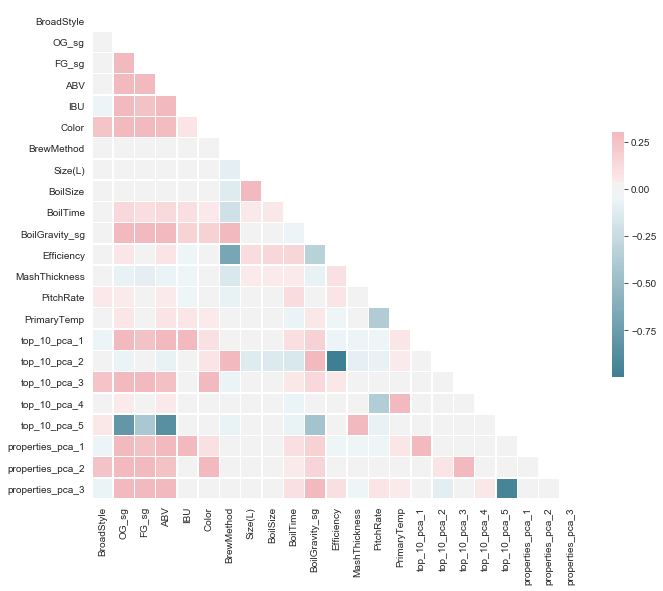

In [494]:
# correlation heatmap

corr = data_to_model.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


<function matplotlib.pyplot.show(*args, **kw)>

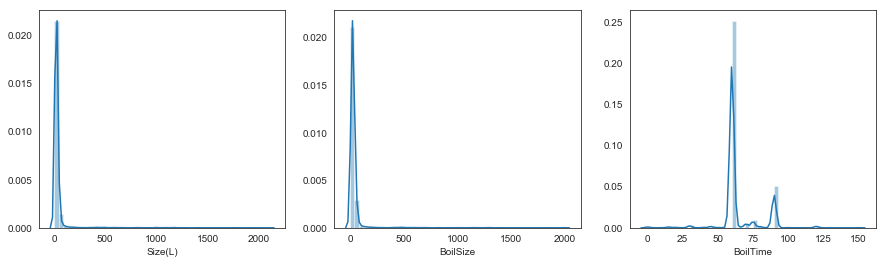

In [492]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.distplot(beer_recipes['Size(L)'])
plt.subplot(1, 3, 2)
sns.distplot(beer_recipes['BoilSize'])
plt.subplot(1, 3, 3)
sns.distplot(beer_recipes['BoilTime'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

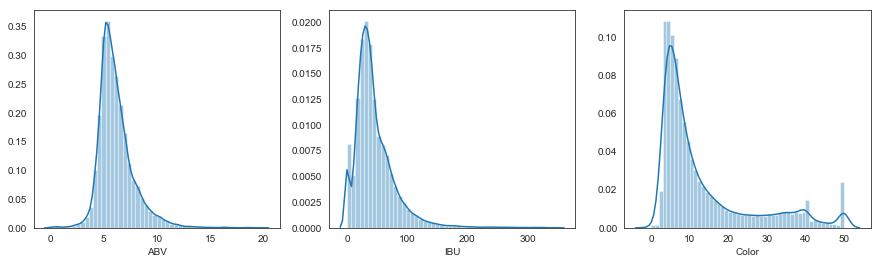

In [490]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.distplot(beer_recipes['ABV'])
plt.subplot(1, 3, 2)
sns.distplot(beer_recipes['IBU'])
plt.subplot(1, 3, 3)
sns.distplot(beer_recipes['Color'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

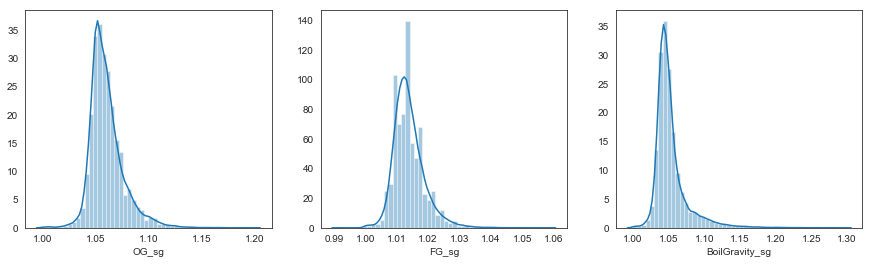

In [491]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.distplot(beer_recipes['OG_sg'])
plt.subplot(1, 3, 2)
sns.distplot(beer_recipes['FG_sg'])
plt.subplot(1, 3, 3)
sns.distplot(beer_recipes['BoilGravity_sg'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

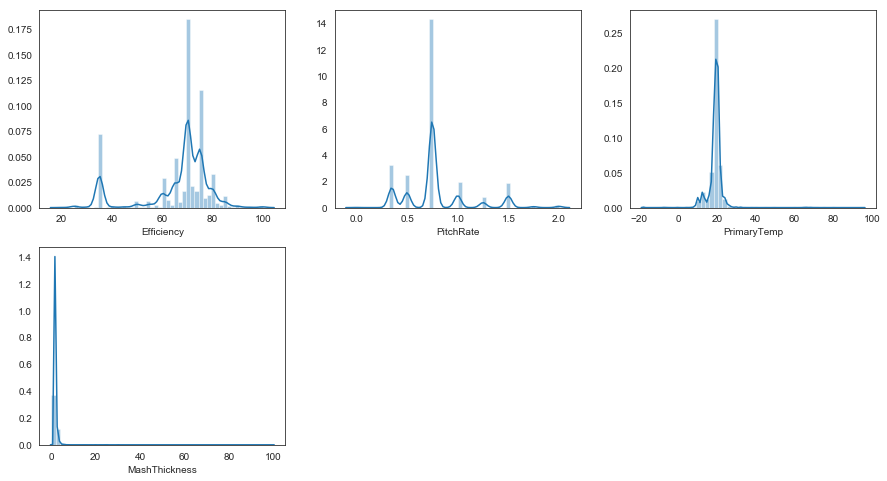

In [493]:
plt.figure(figsize=(15,8))
plt.subplot(2, 3, 1)
sns.distplot(beer_recipes['Efficiency'])
plt.subplot(2, 3, 2)
sns.distplot(beer_recipes['PitchRate'])
plt.subplot(2, 3, 3)
sns.distplot(beer_recipes['PrimaryTemp'])
plt.subplot(2, 3, 4)
sns.distplot(beer_recipes['MashThickness'])
plt.show